## 1. Loading the necessary packages

In [3]:
# Loading packages
import importlib
import subprocess
import sys
import os

def install_and_import(package, import_name=None):
    """
    Try to import a package. If it's not installed, install it via pip and import again.
    package: name on pip (e.g. 'pandas')
    import_name: name used in import (e.g. 'pandas' or 'matplotlib.pyplot').
                 If None, uses package.
    """
    if import_name is None:
        import_name = package

    try:
        return importlib.import_module(import_name)
    except ImportError:
        print(f"{import_name} not found, installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        return importlib.import_module(import_name)

# use it for your libs
pd = install_and_import("pandas")
np = install_and_import("numpy")
mpl = install_and_import("matplotlib")
plt = install_and_import("matplotlib.pyplot", "matplotlib.pyplot")


xgb = install_and_import("xgboost")
from xgboost import XGBRegressor, plot_importance            # XGBoost regression model and feature importance measure
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score


seed = 314+133+76223+3+5
np.random.seed(seed)


## 2. Loading the data

In [5]:
import pandas as pd

filtered_df_anal = pd.read_csv(r"C:\Users\User\Downloads\filtered_data_anal(2).csv")

# első pár sor ellenőrzéshez:
print(filtered_df_anal.head())



   site_id_(telephely)  class_size  math_score_8_std mother_education_level  \
0              3512501          26          1.367778  apprenticeship_school   
1              3338601          22         -0.700054  secondary_with_matura   
2              3352101          17         -2.378011      less_than_primary   
3              2911501          22         -1.596259      less_than_primary   
4              3772301          19          0.777019  secondary_with_matura   

  father_education_level books_at_home  family_background_index_std  \
0                college     up_to_300                     0.318596   
1  secondary_with_matura       300_600                     0.536068   
2         primary_school          0_50                    -2.399800   
3      less_than_primary     around_50                    -2.182328   
4  secondary_with_matura     up_to_150                     0.698790   

  student_gender class_curriculum_type multiplied_disadvantaged  \
0           girl               

## 3. Defining target variable and preparing features for XGBoost

In [9]:
# Step 1: Define target and features
target = "math_score_8_std"                 # Target variable to predict

# Build list of columns to drop safely (only those that exist in the DataFrame)
cols_to_drop = [target] 
cols_to_drop = [c for c in cols_to_drop if c in filtered_df_anal.columns]

print("Target:", target)

# Feature matrix X and target vector y
# Feature matrix X and target vector y
X = filtered_df_anal.drop(columns=cols_to_drop).copy()   # All predictors
y = filtered_df_anal[target].copy()                      # Outcome

# Step 2: Handle categorical (object) data
# XGBoost needs numeric or pandas 'category' dtypes
cat_cols = X.select_dtypes(include=["object"]).columns
X[cat_cols] = X[cat_cols].astype("category")

Target: math_score_8_std


## 4. Train–test split and XGBoost hyperparameter tuning setup

In [10]:
# Step 3: Train–test split (80–20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=76678
)
# Step 4: Base XGBoost model
base_model = XGBRegressor(
    objective="reg:squarederror",  # Explicit regression objective
    tree_method="hist",            # Required for categorical support / efficiency
    enable_categorical=True,       # Tell XGBoost that we use categorical features
    random_state=76678,
)

# Step 5: Hyperparameter search space (Randomized)
param_distributions = {
    "n_estimators": [100, 200, 300, 500, 700],
    "learning_rate": [0.01, 0.03, 0.05, 0.1, 0.15, 0.2],
    "max_depth": [3, 4, 5, 6, 7, 8, 10],
    "subsample": [0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "reg_lambda": [0, 1, 2, 5, 10],             # L2 regularization
    "reg_alpha": [0, 0.1, 0.25, 0.5, 0.75, 1],  # L1 regularization
}

random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_distributions,
    n_iter=30,                         # Number of sampled hyperparameter combinations
    scoring="neg_root_mean_squared_error",  # Minimize RMSE
    cv=5,                              # 5-fold cross-validation
    verbose=1,
    n_jobs=-1,                         # Use all available cores
    random_state=76678,
)

## 5. Training the tuned XGBoost model and evaluating performance

In [11]:
# Step 6: Fit hyperparameter search & evaluate model
random_search.fit(X_train, y_train)

# Best model after tuning
model = random_search.best_estimator_

print("Best hyperparameters:", random_search.best_params_)

# Predictions on test set
y_pred = model.predict(X_test)

# Regression metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R^2:", r2)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best hyperparameters: {'subsample': 1.0, 'reg_lambda': 0, 'reg_alpha': 0.75, 'n_estimators': 700, 'max_depth': 4, 'learning_rate': 0.15, 'colsample_bytree': 0.8}
RMSE: 0.7925342808887187
R^2: 0.3203128901262986


## 6. Visualizing model performance: true vs. predicted values

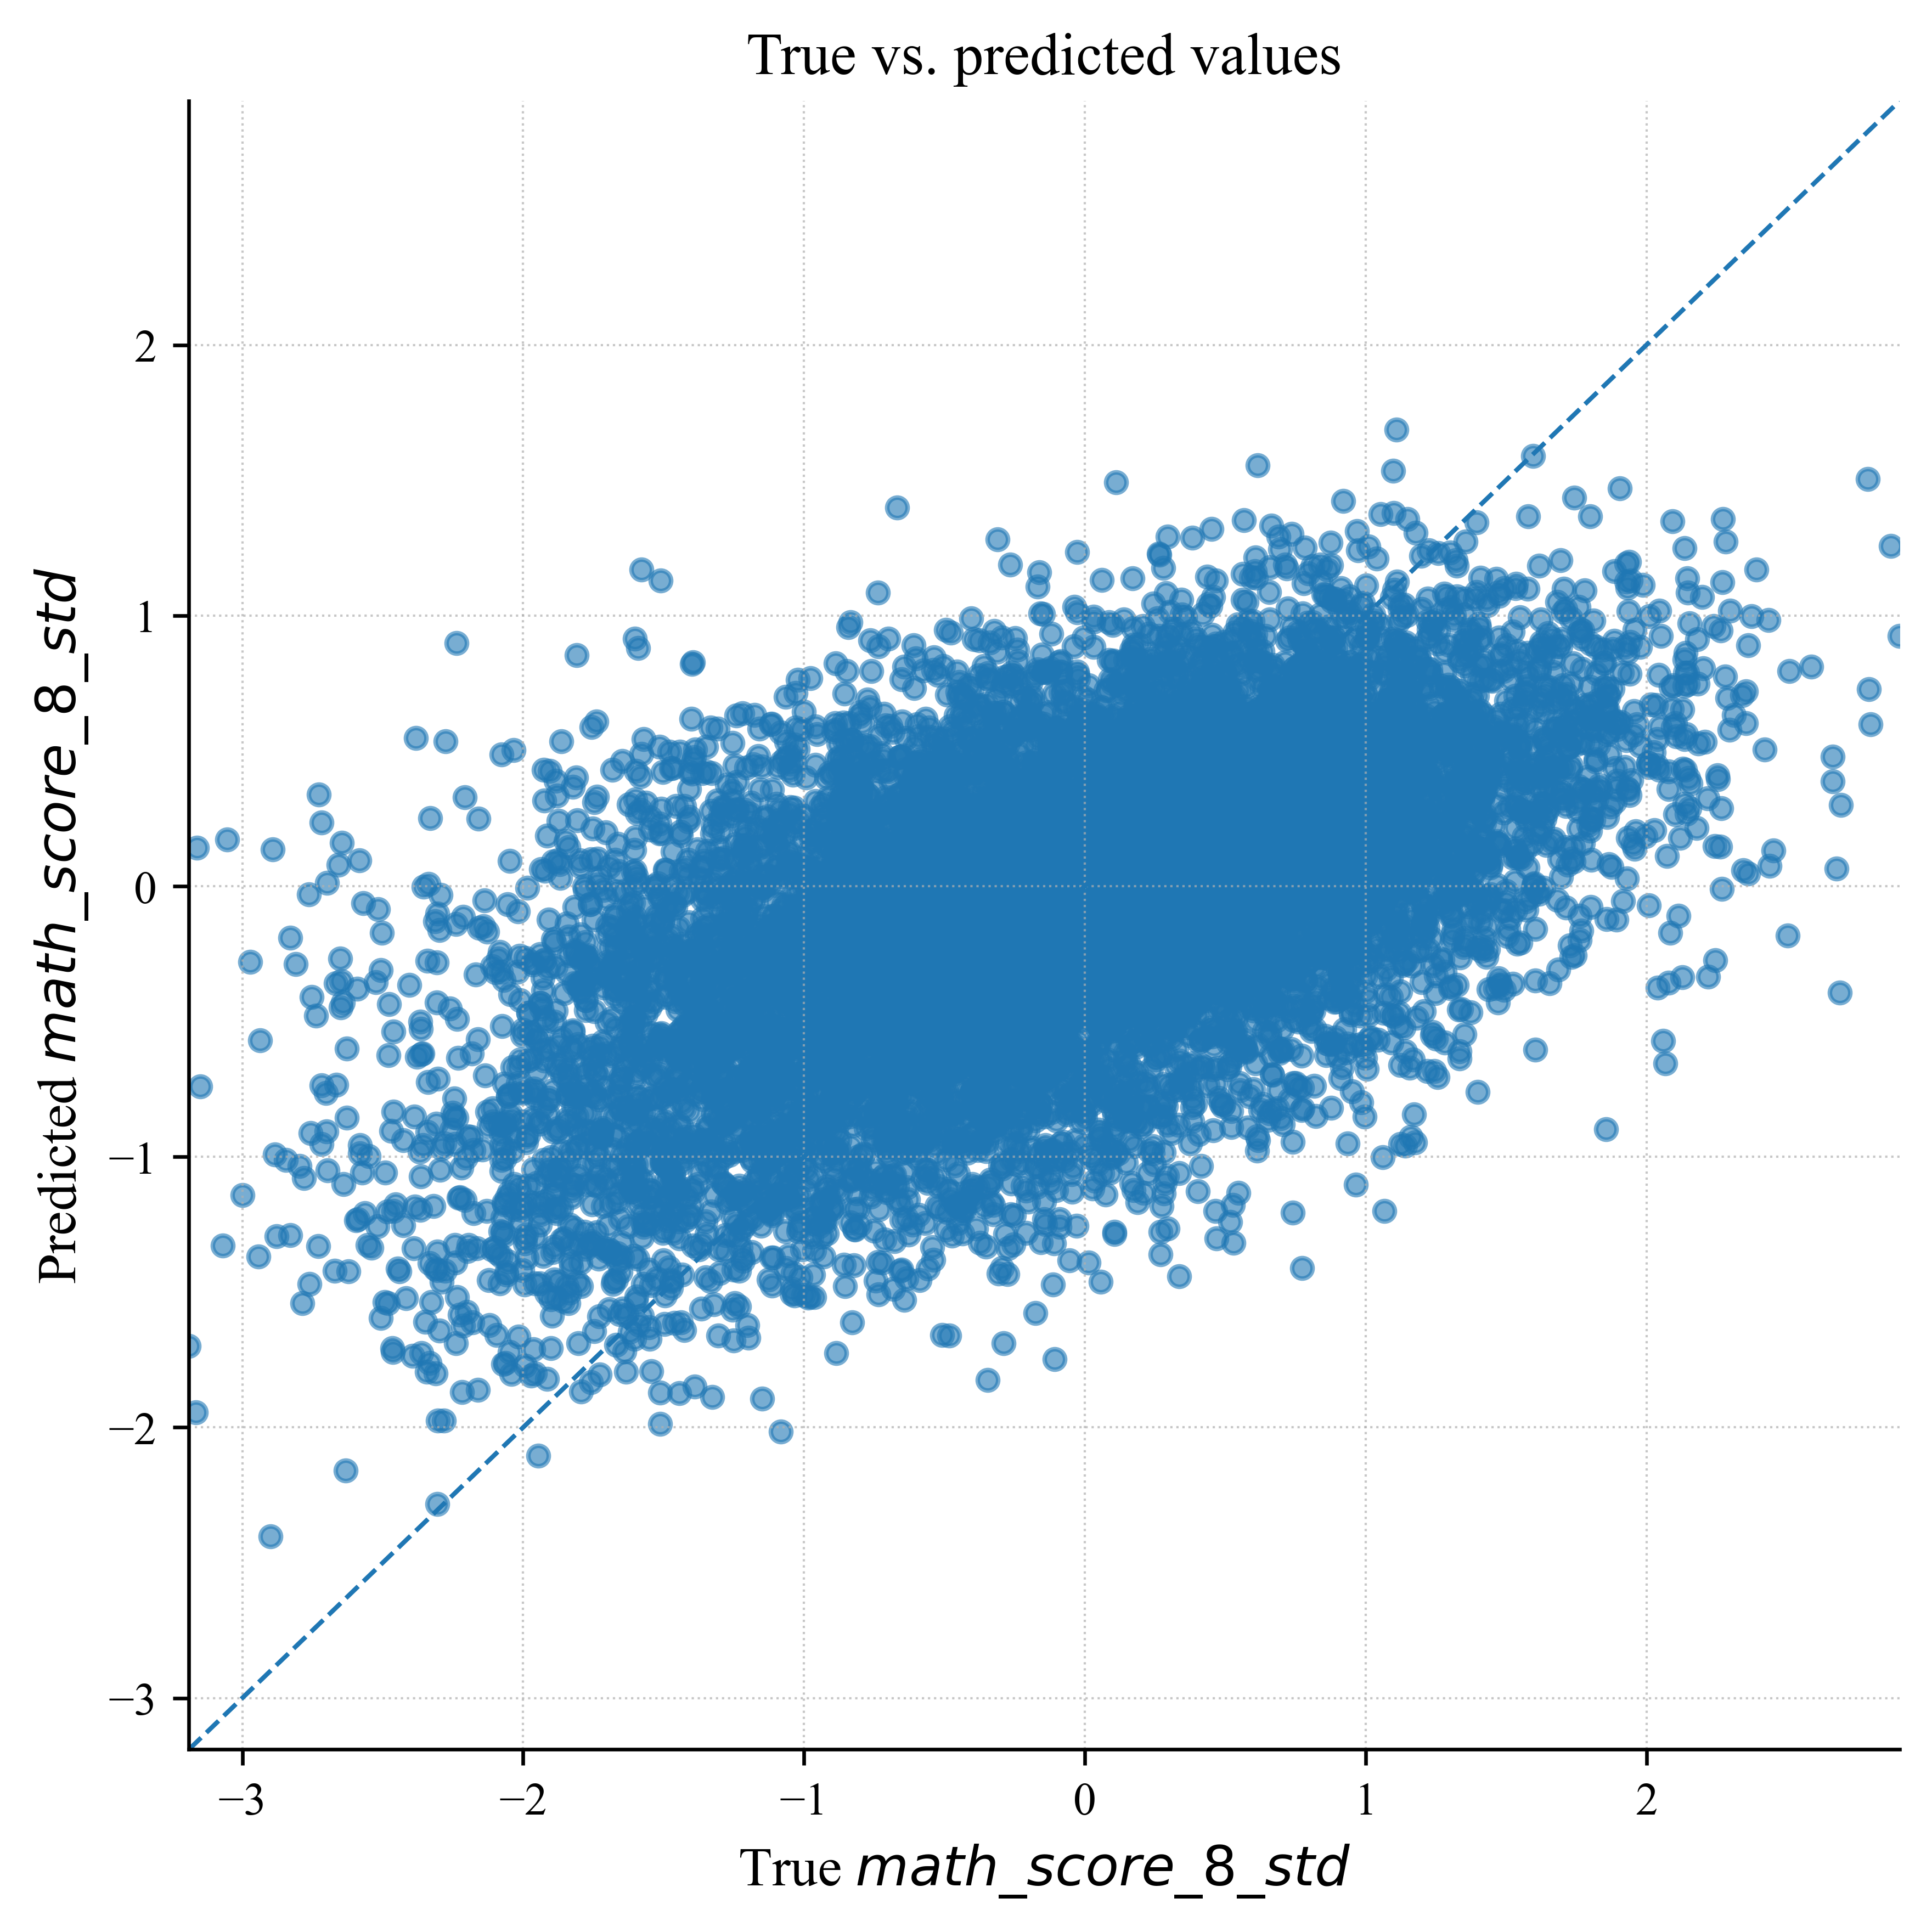

In [17]:
# Global plotting style for publication-quality figures
mpl.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 11,
    "axes.titlesize": 13,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "figure.dpi": 600,
})

save_dir = r"C:\Users\User\Desktop\Figures\Figures"
os.makedirs(save_dir, exist_ok=True)

# -------------------------------------------------------------------
# Plot1. True vs. predicted values
# -------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 6))

ax.scatter(y_test, y_pred, s=20, alpha=0.6)
ax.set_xlabel("True $math\\_score\\_8\\_std$")
ax.set_ylabel("Predicted $math\\_score\\_8\\_std$")
ax.set_title("True vs. predicted values")

min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
ax.plot([min_val, max_val], [min_val, max_val],
        linestyle="--", linewidth=1)

ax.set_xlim(min_val, max_val)
ax.set_ylim(min_val, max_val)

ax.grid(True, linestyle=":", linewidth=0.5, alpha=0.7)

fig.tight_layout()
fig.savefig(os.path.join(save_dir, "true_vs_predicted.png"), dpi=600)

plt.show()
plt.close(fig)

## 7. Visualizing residuals: distribution of prediction errors

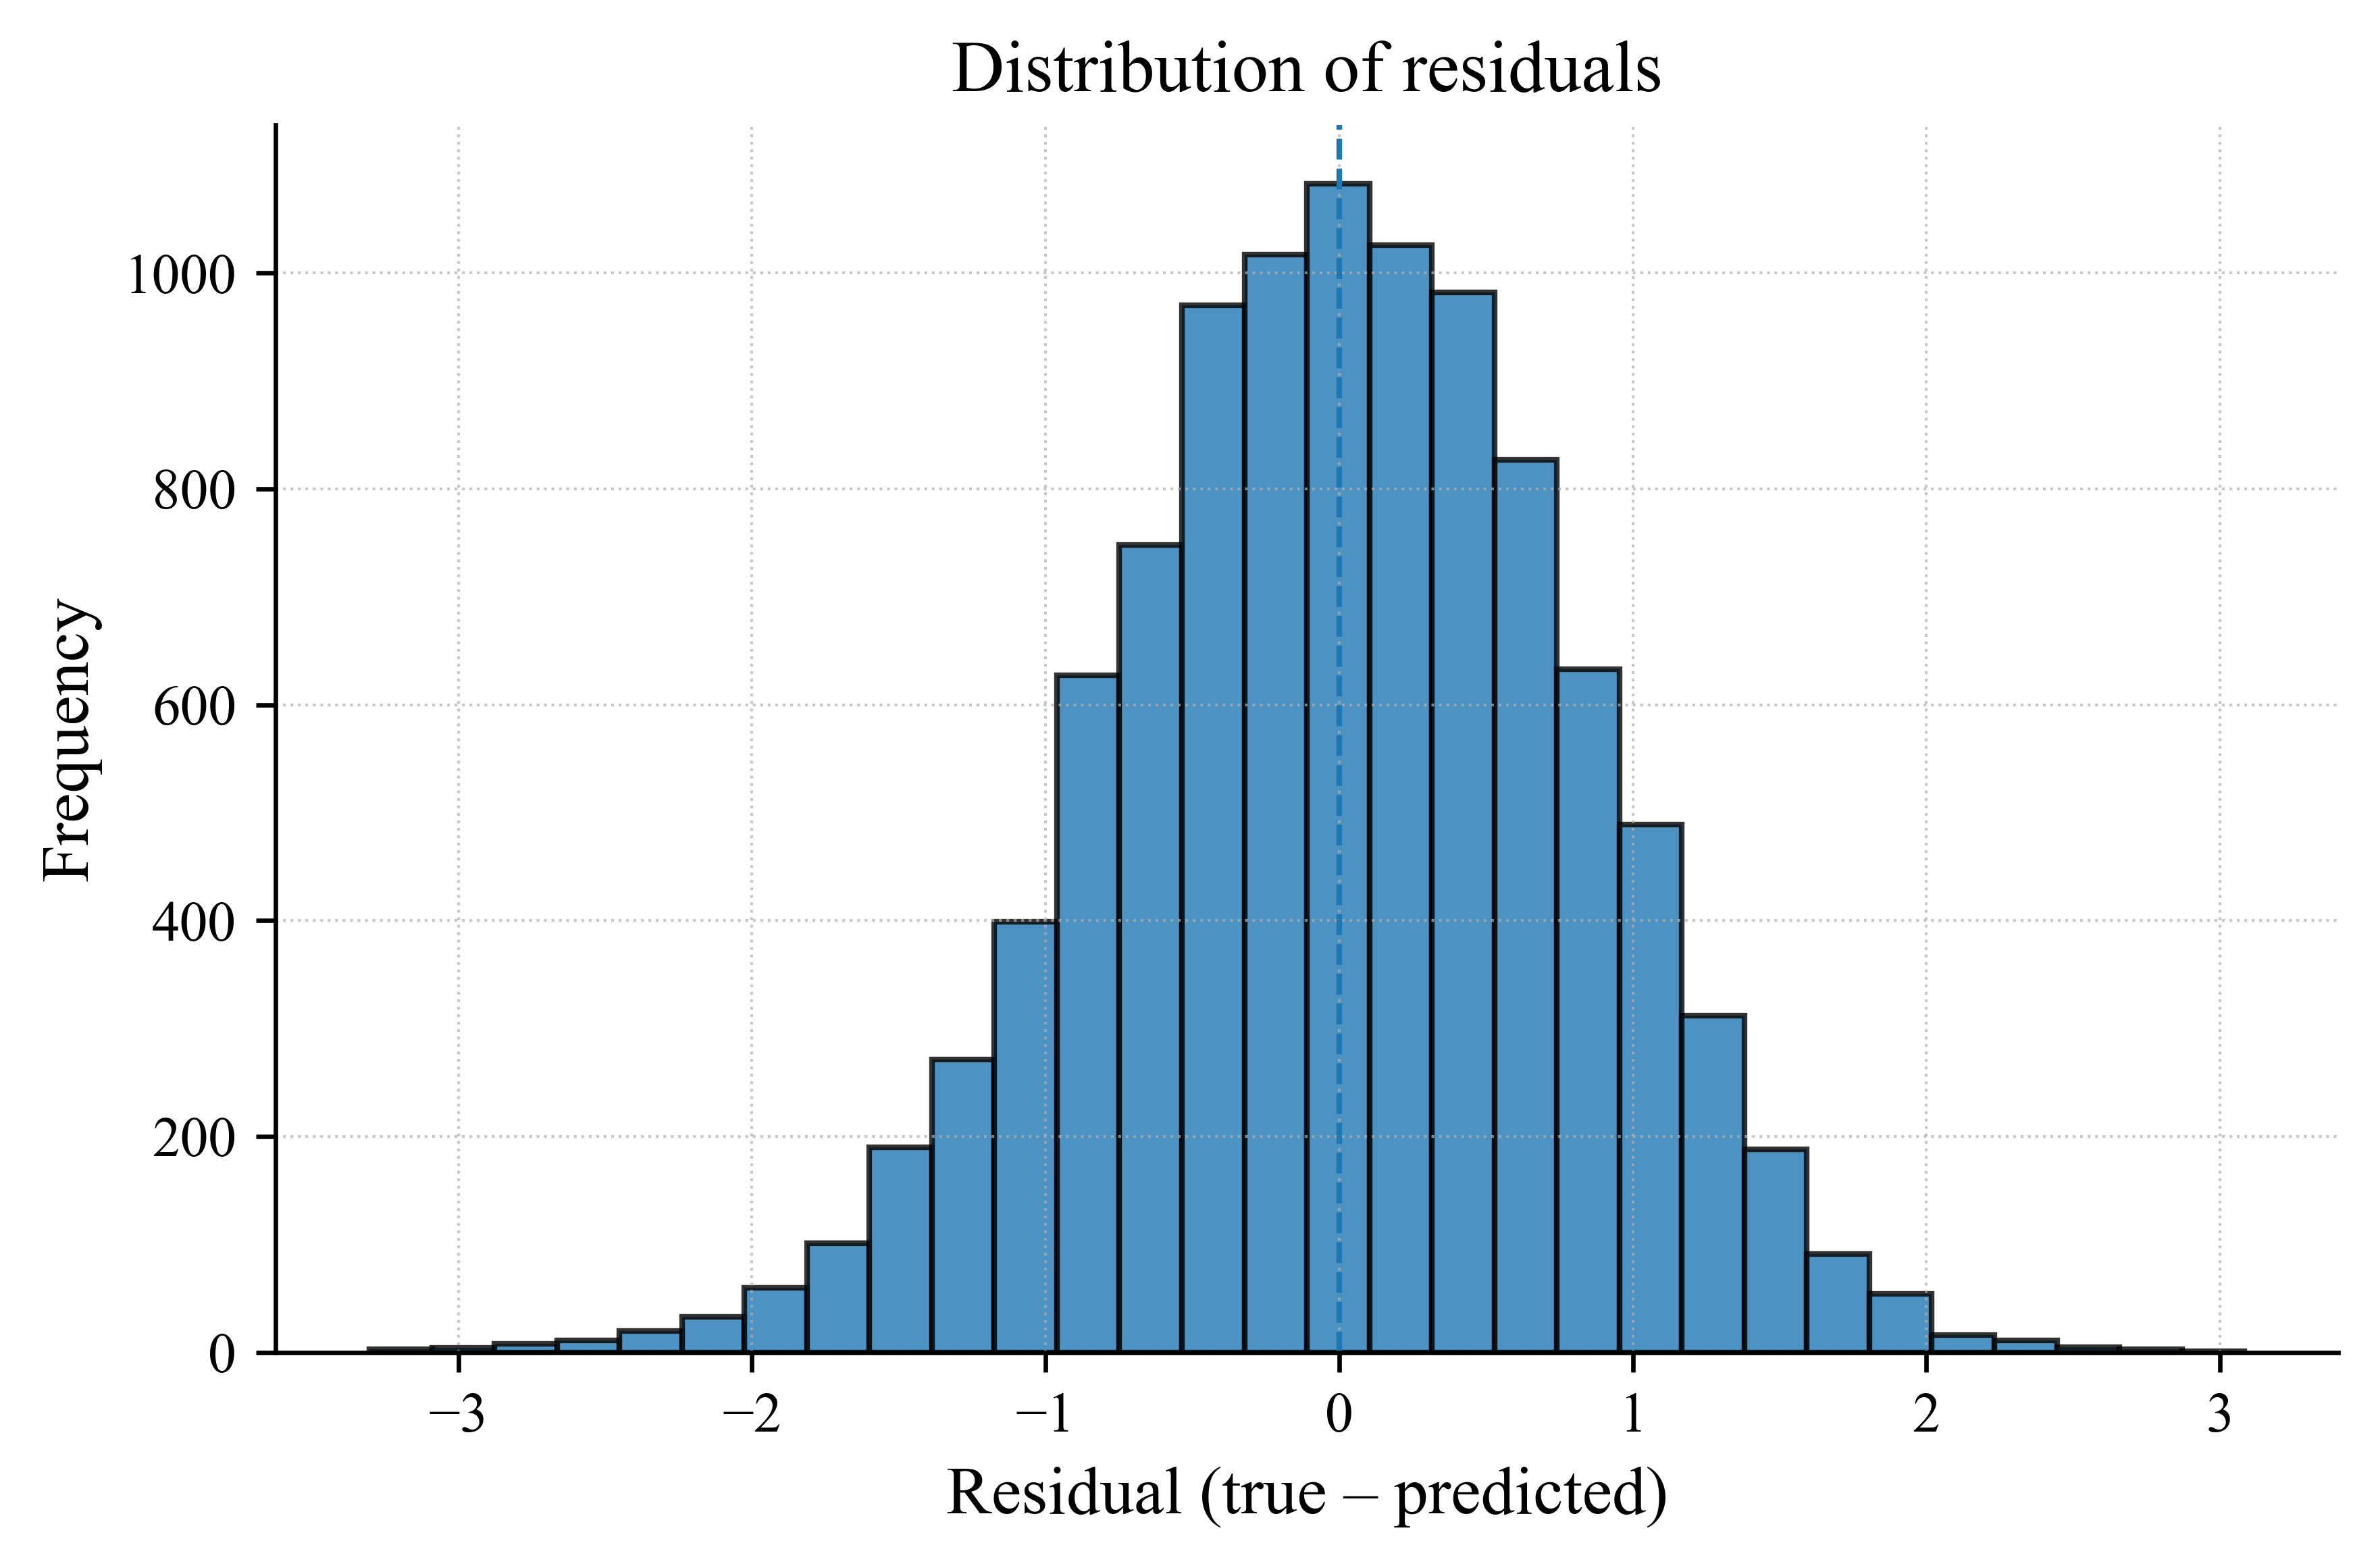

In [17]:
# -------------------------------------------------------------------
# Plot2. Residuals histogram
# -------------------------------------------------------------------
residuals = y_test - y_pred

fig, ax = plt.subplots(figsize=(6, 4))

ax.hist(residuals, bins=30, edgecolor="black", alpha=0.8)
ax.set_xlabel("Residual (true – predicted)")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of residuals")

ax.axvline(0, linestyle="--", linewidth=1)

ax.grid(True, linestyle=":", linewidth=0.5, alpha=0.7)

fig.tight_layout()
fig.savefig(os.path.join(save_dir, "residuals_histogram.png"), dpi=600)

plt.show()
plt.close(fig)

## 8. Visualizing residuals vs. predicted values

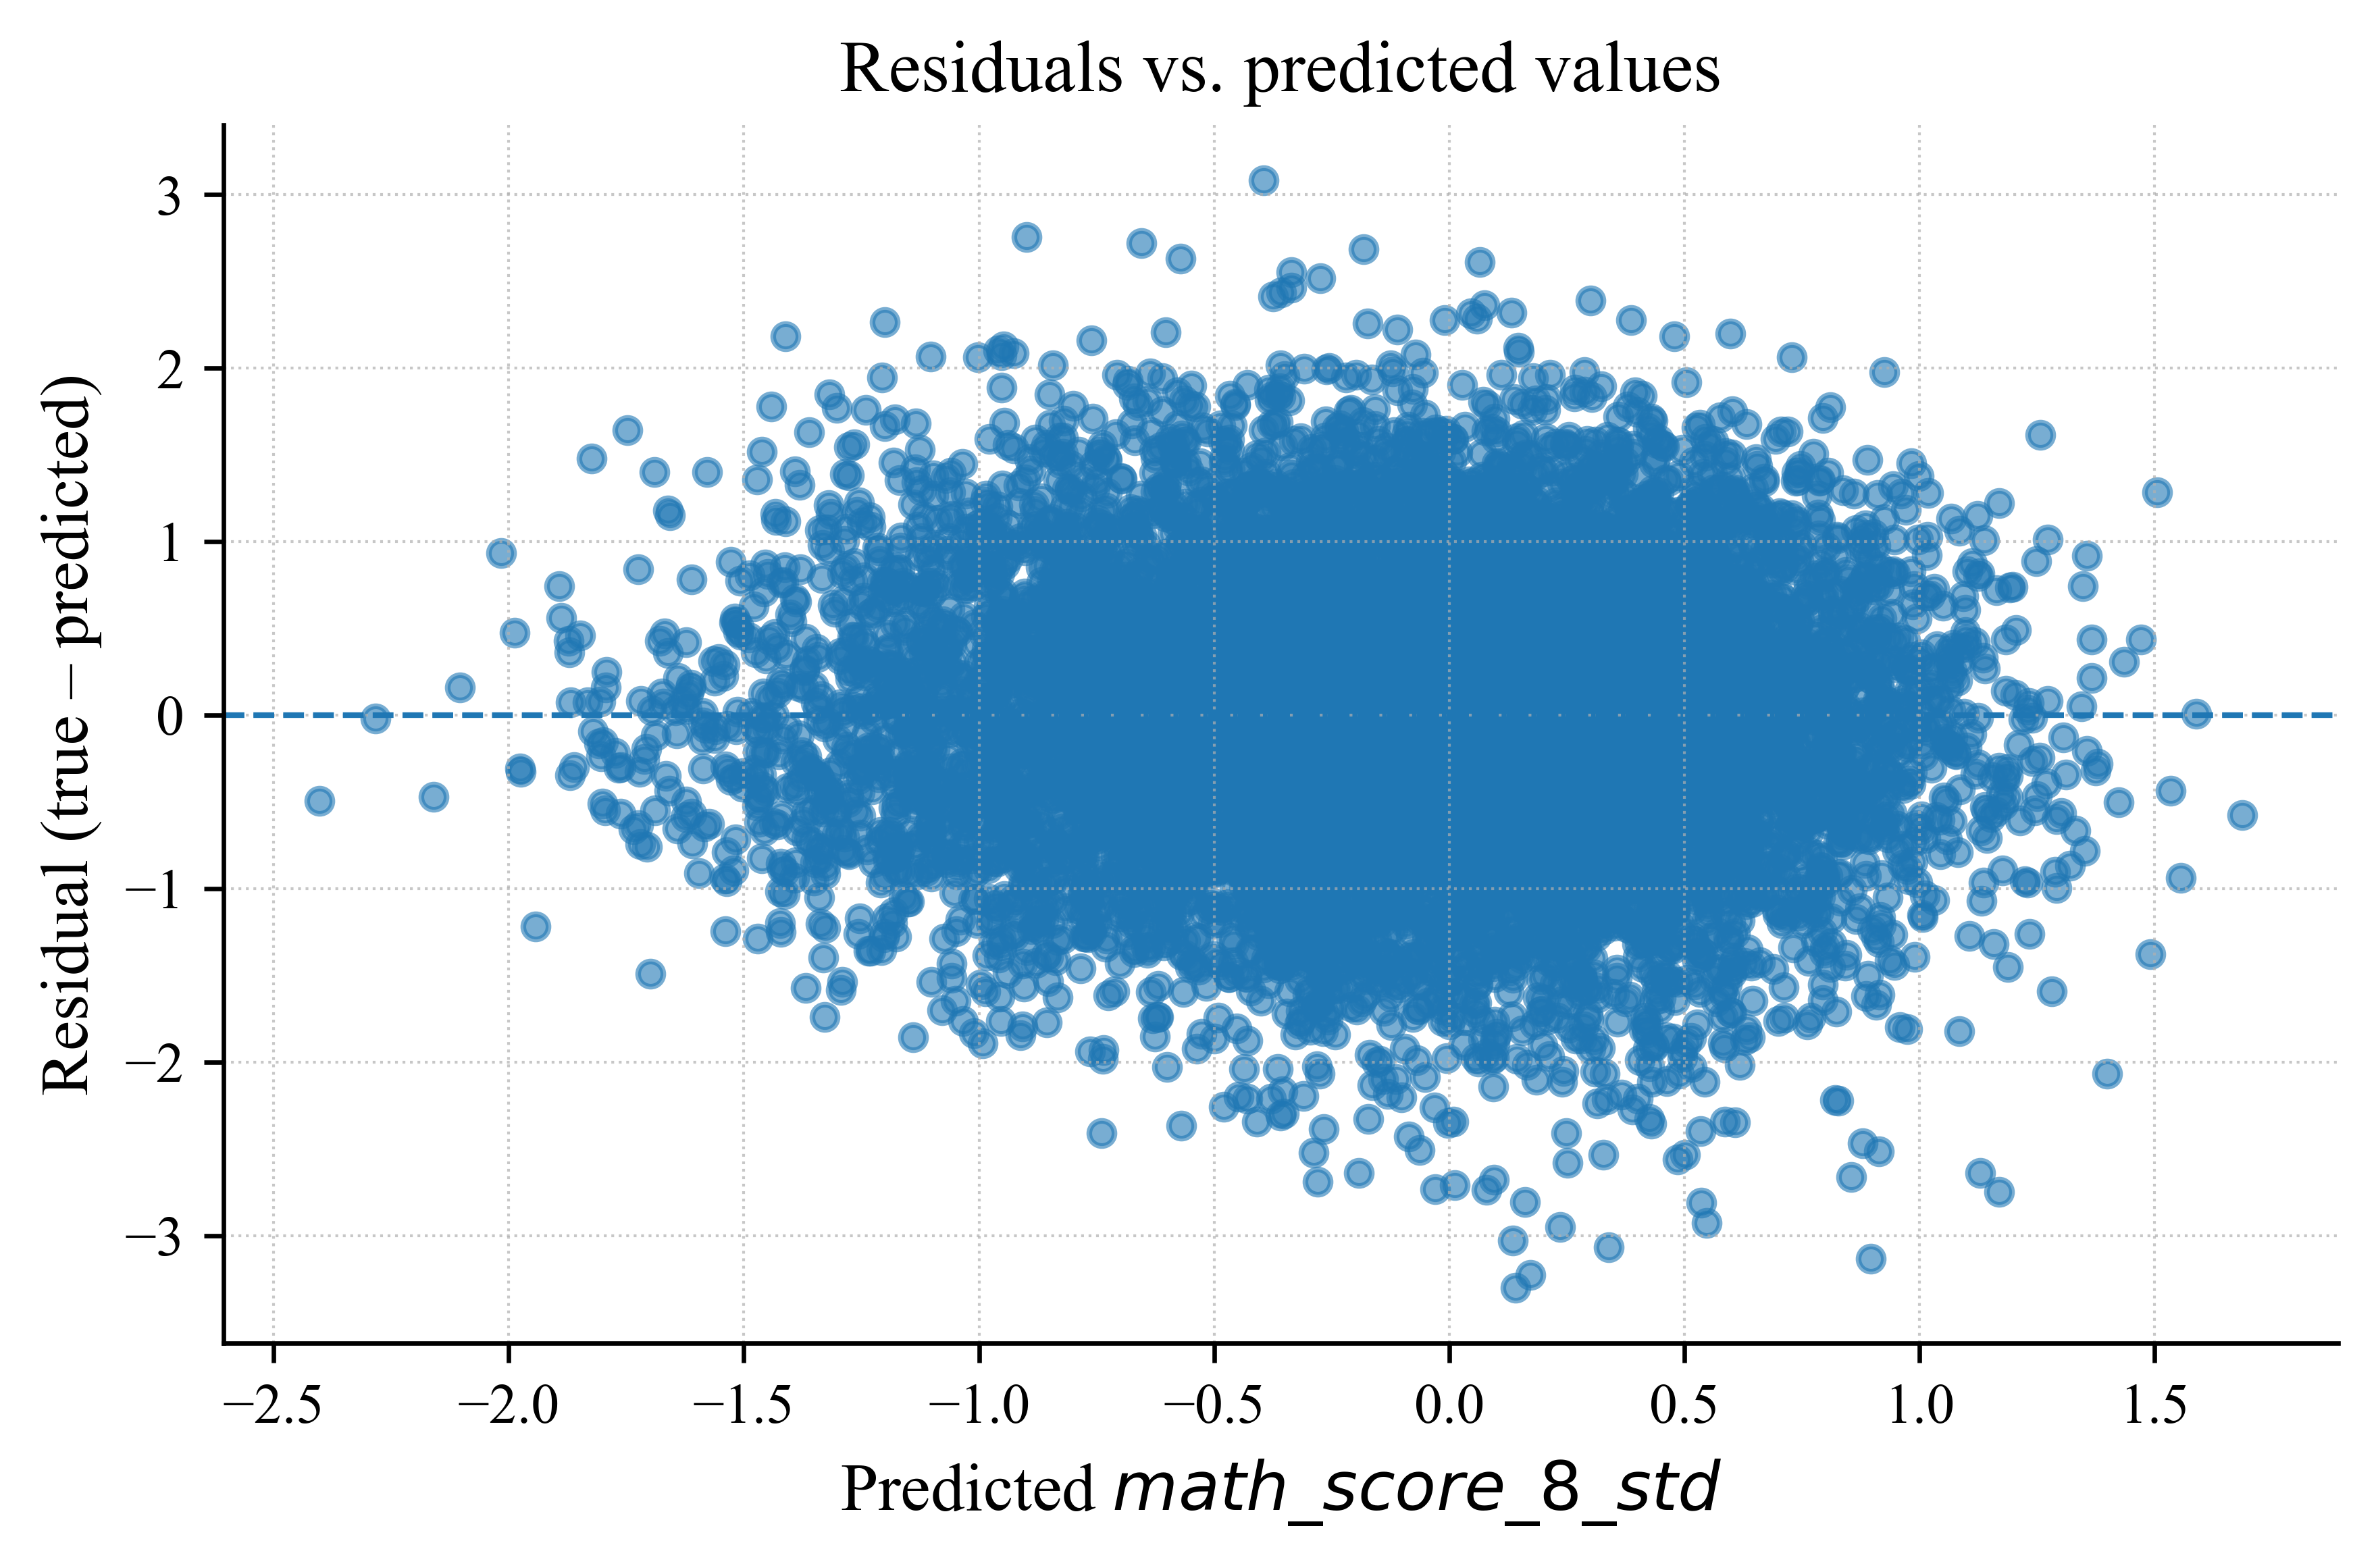

In [19]:
# -------------------------------------------------------------------
# Plot3. Residuals vs. fitted values
# -------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 4))

ax.scatter(y_pred, residuals, s=20, alpha=0.6)
ax.axhline(0, linestyle="--", linewidth=1)

ax.set_xlabel("Predicted $math\\_score\\_8\\_std$")
ax.set_ylabel("Residual (true – predicted)")
ax.set_title("Residuals vs. predicted values")

ax.grid(True, linestyle=":", linewidth=0.5, alpha=0.7)

fig.tight_layout()
fig.savefig(os.path.join(save_dir, "residuals_vs_fitted.png"), dpi=600)

plt.show()
plt.close(fig)

## 9. Interpreting the model: top 20 XGBoost feature importances

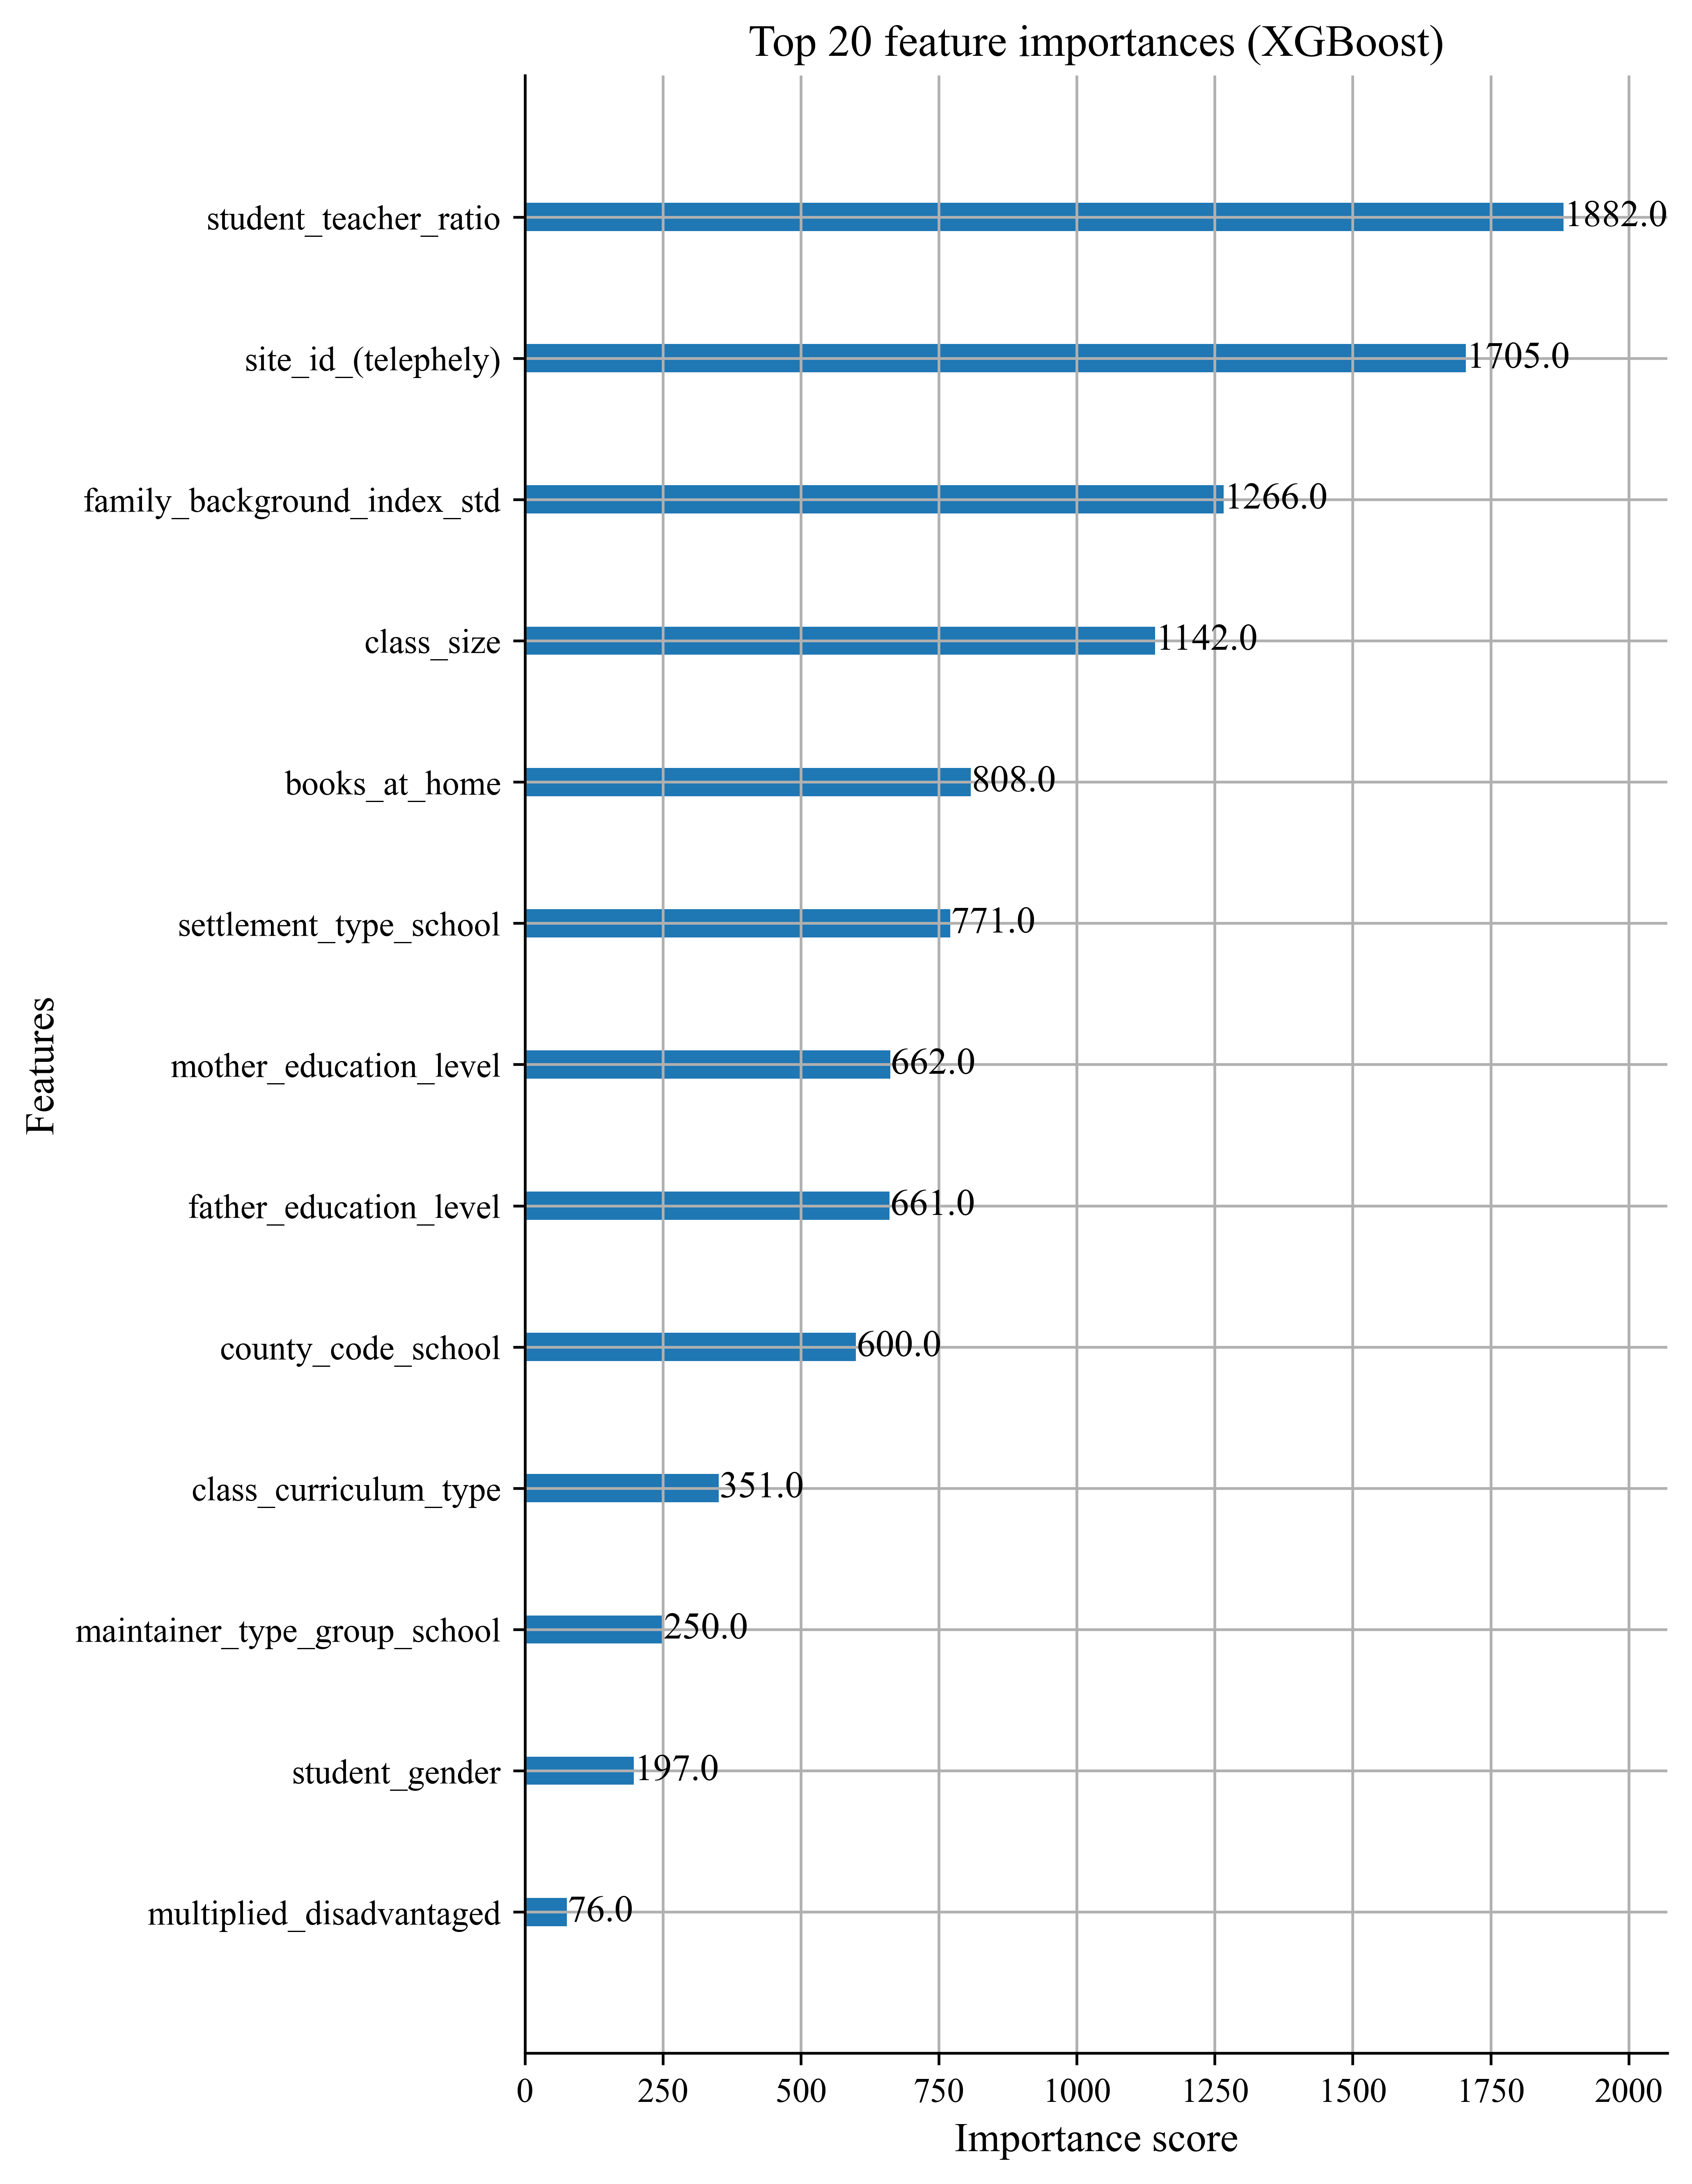

In [21]:
# -------------------------------------------------------------------
# Plot4. Feature importance (XGBoost)
# -------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 9))

plot_importance(
    model,
    max_num_features=20,
    ax=ax
)

ax.set_title("Top 20 feature importances (XGBoost)")

fig.tight_layout()
fig.savefig(os.path.join(save_dir, "feature_importance.png"), dpi=600)

plt.show()
plt.close(fig)